# MLP and Regularization (Dropout, Normalization)
---

#### Goals

1. Make Multi Layer Perceptron with nn.Module Class
2. Improve performance with Reguralization
    - Batch normalization
    - Dropout

---

## 1. Library Importation & Device Preparation

In [9]:
# Library Importation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from multiprocessing import cpu_count
from sklearn.metrics import confusion_matrix
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

MNIST.resources = [
  (
    'https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz',
    'f68b3c2dcbeaaa9fbdd348bbdeb94873'
  ), (
    'https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz',
    'd53e105ee54ea40749a09fcbcd1e9432'
  ), (
    'https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz',
    '9fb629c4189551a2d022fa330f9573f3'
  ), (
    'https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz',
    'ec29112dd5afa0611ce80d1b7f02629c'
  )
]

# Device Preparation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

GPU will be used in training/validation.


## 2. Hyper-parameters

By executing below blocks, you can initialize/update hyper-parameters.

In [10]:
# Data Loader
batch_size = 32

# Model
hidden_layer = 200

# Learning
logging_dispfig = True
maximum_epoch = 25
learning_rate = 0.1

## 3. Data Load & Preprocessing

Because MNIST dataset is already well-preprocessed imageset, we will not perform any preprocessing today.

===================== Check the data =========================

Train dataset length = 54000
Valid dataset length = 6000
Test dataset length = 10000

Content of Y (Label, type=<class 'int'>) = 2
Shape of X (Data, type=<class 'torch.Tensor'>) = torch.Size([1, 28, 28])


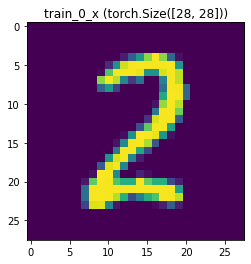

================== Check the data loader ======================

Idx: 0 / X.shape = torch.Size([32, 1, 28, 28]) / Y.shape = torch.Size([32])

Y[0:32] = tensor([3, 8, 4, 8, 8, 5, 2, 2, 8, 7, 2, 5, 0, 3, 5, 4, 8, 8, 2, 0, 5, 6, 6, 5,
        2, 6, 6, 7, 3, 8, 9, 3])


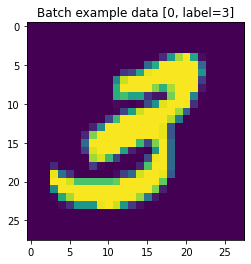

In [11]:
# Load dataset into python variable
train_data = MNIST("./", train=True, transform=ToTensor(), target_transform=None, download=True)
train_data, valid_data = random_split(train_data, [54000, 6000])
test_data = MNIST("./", train=False, transform=ToTensor(), target_transform=None, download=True)

# Check the data
print('===================== Check the data =========================\n')
print(f'Train dataset length = {len(train_data)}')
print(f'Valid dataset length = {len(valid_data)}')
print(f'Test dataset length = {len(test_data)}\n')

train_0_x, train_0_y = train_data[0]
print(f'Content of Y (Label, type={type(train_0_y)}) = {train_0_y}')
print(f'Shape of X (Data, type={type(train_0_x)}) = {train_0_x.shape}')
plt.figure(1)
plt.imshow(train_0_x.squeeze())
plt.title(f'train_0_x ({train_0_x.squeeze().shape})')
plt.show()

# Create data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

# Examine the data loader
print('================== Check the data loader ======================\n')
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0:{batch_size}] = {ex_label}')

preview_index = 0
plt.figure(2)
plt.imshow(ex_data[preview_index, 0, :, :])
plt.title(f'Batch example data [{preview_index}, label={ex_label[preview_index]}]')
plt.show()

## 4. Function Definitions

Because our model is too simple now, we will use just `nn.Linear` module and wrap it with initializer function instead of defining a model class.

In [17]:
# Model
def init_model(_net):
    global net, loss_fn, optim
    net = _net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = SGD(net.parameters(), lr=learning_rate)

# Epoch
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

    
def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_out, last_label = None, None
    last_grad_performed = False

    # Mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.view([len(_data), -1]).to(device), _label.to(device)

        # 1. Feed-forward
        onehot_out = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in `torch.no_grad()`
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

        # 5. Save current iteration data for future use
        last_out = out.cpu().detach()
        last_label = _label

    # Up epoch count if backward propagation is done
    if last_grad_performed:
        epoch_cnt += 1

    return np.average(iter_loss), np.average(iter_acc), last_out, last_label


def epoch_not_finished():
    # For now, let's repeat training fixed times, e.g. 25 times.
    # We will learn how to determine training stop or continue later.
    return epoch_cnt < maximum_epoch

# Logging
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []
  
  
def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
  
  
def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

    
def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1


def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    log_stack.append(log_str)
  
  # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()
    
  # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

## 5. Model Architectures

In [14]:
class OneLayerModel(nn.Module):
    def __init__(self):
        super(OneLayerModel, self).__init__()
        
        self.fc1 = nn.Linear(len(train_0_x.view([-1])), hidden_layer, bias=False)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer, 10, bias=False)
        
    def forward(self, x):
        out = self.fc1(x)
        hidden = self.act(out)
        onehot_out = self.fc2(hidden)
        
        return onehot_out

## 6. Training Iteration & Test Result (Yesterday)

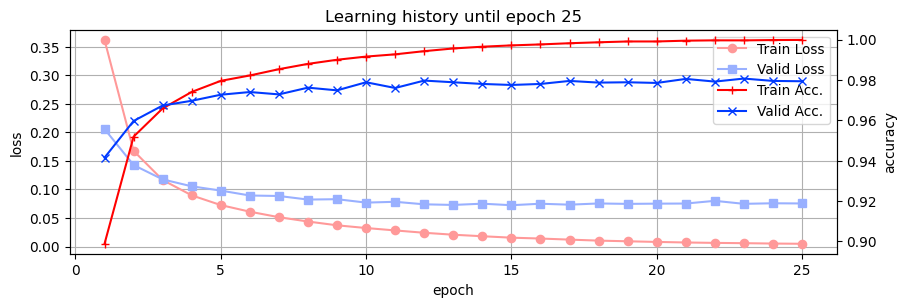

Iter:   25 >> T_loss 0.00477    T_acc 0.99980   V_loss 0.07539    V_acc 0.97933   🕒 5.320s
Iter:   24 >> T_loss 0.00518    T_acc 0.99974   V_loss 0.07571    V_acc 0.97950   🕒 5.362s
Iter:   23 >> T_loss 0.00583    T_acc 0.99957   V_loss 0.07474    V_acc 0.98067   🕒 5.330s
Iter:   22 >> T_loss 0.00634    T_acc 0.99959   V_loss 0.07998    V_acc 0.97917   🕒 5.373s
Iter:   21 >> T_loss 0.00705    T_acc 0.99943   V_loss 0.07525    V_acc 0.98050   🕒 5.409s
Iter:   20 >> T_loss 0.00802    T_acc 0.99904   V_loss 0.07506    V_acc 0.97850   🕒 5.395s
Iter:   19 >> T_loss 0.00915    T_acc 0.99904   V_loss 0.07464    V_acc 0.97883   🕒 4.930s
Iter:   18 >> T_loss 0.01030    T_acc 0.99863   V_loss 0.07540    V_acc 0.97867   🕒 5.357s
Iter:   17 >> T_loss 0.01208    T_acc 0.99817   V_loss 0.07327    V_acc 0.97950   🕒 4.543s
Iter:   16 >> T_loss 0.01395    T_acc 0.99757   V_loss 0.07491    V_acc 0.97800   🕒 4.680s
Iter:   15 >> T_loss 0.01547    T_acc 0.99709   V_loss 0.07233    V_acc 0.97750   🕒 5.313s

In [18]:
# Training Initialization
init_model(OneLayerModel())
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

# Accuracy for test dataset
with torch.no_grad():
    test_loss, test_acc, test_out, test_label = epoch(test_loader)
    print('\n====================== Test Result ======================\n')
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')

## 6-1. Training Iteration & Test Result (MLP)

In [21]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLP, self).__init__()
        
        self.hidden_layer1 = 165
        self.hidden_layer2 = 165
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(self.hidden_layer2, out_features)
        
    def forward(self, x):
        hidden1 = self.act1(self.fc1(x))
        hidden2 = F.relu(self.fc2(hidden1))
        
        onehot_out = self.fc3(hidden2)        
        return onehot_out

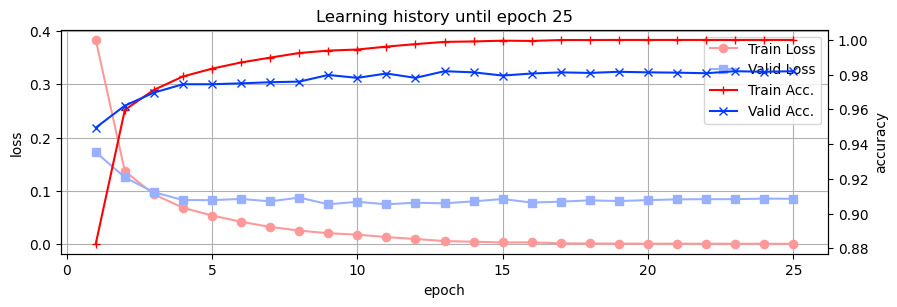

Iter:   25 >> T_loss 0.00043    T_acc 1.00000   V_loss 0.08499    V_acc 0.98200   🕒 6.335s
Iter:   24 >> T_loss 0.00046    T_acc 1.00000   V_loss 0.08537    V_acc 0.98167   🕒 6.215s
Iter:   23 >> T_loss 0.00052    T_acc 0.99998   V_loss 0.08431    V_acc 0.98200   🕒 6.028s
Iter:   22 >> T_loss 0.00055    T_acc 1.00000   V_loss 0.08432    V_acc 0.98083   🕒 6.289s
Iter:   21 >> T_loss 0.00061    T_acc 1.00000   V_loss 0.08394    V_acc 0.98117   🕒 6.250s
Iter:   20 >> T_loss 0.00069    T_acc 1.00000   V_loss 0.08252    V_acc 0.98133   🕒 5.125s
Iter:   19 >> T_loss 0.00082    T_acc 1.00000   V_loss 0.08079    V_acc 0.98167   🕒 4.985s
Iter:   18 >> T_loss 0.00097    T_acc 0.99996   V_loss 0.08208    V_acc 0.98100   🕒 6.310s
Iter:   17 >> T_loss 0.00136    T_acc 0.99994   V_loss 0.07967    V_acc 0.98133   🕒 6.306s
Iter:   16 >> T_loss 0.00309    T_acc 0.99943   V_loss 0.07791    V_acc 0.98067   🕒 6.276s
Iter:   15 >> T_loss 0.00292    T_acc 0.99957   V_loss 0.08457    V_acc 0.97950   🕒 6.328s

In [22]:
# Training Initialization
init_model(MLP(len(train_0_x.view([-1])), 10))
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

# Accuracy for test dataset
with torch.no_grad():
    test_loss, test_acc, test_out, test_label = epoch(test_loader)
    print('\n====================== Test Result ======================\n')
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')

## 7. Batch Normalization

### Look inside of Network

In [23]:
def plot_inner_dist():
    for epoch in range(10):
        net.train()
        for _data, _label in train_loader:
            data, label = _data.view([len(_data), -1]).to(device), _label.to(device)

            # Feed-forward
            _, _, _, _, onehot_out = net(data)
            loss = loss_fn(onehot_out, label)

            # Backward propagation
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        net.eval()
        with torch.no_grad():
            for _data, _label in test_loader:
                data, label = _data.view([len(_data), -1]).to(device), _label.to(device)

                # Feed-forward
                o1, h1, o2, h2, onehot_out = net(data)
                
                # calculate accuracy
                _, out = torch.max(onehot_out, 1)
                acc_test = (out == label).float().sum()
                acc_test = acc_test / len(label)

        # plot inner distribution
        o1, h1, o2, h2 = o1.cpu().detach().numpy(), h1.cpu().detach().numpy(), o2.cpu().detach().numpy(), h2.cpu().detach().numpy()
        fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex='col')
        axs[0, 0].hist(o1.reshape(-1))
        axs[0, 1].hist(h1.reshape(-1))
        axs[0, 2].scatter(o1[0], h1[0])
        axs[1, 0].hist(o2.reshape(-1))
        axs[1, 1].hist(h2.reshape(-1))
        axs[1, 2].scatter(o2[0], h2[0])

        clear_output(wait=True)
        print(f'\n### Epoch: {epoch+1}  /  Accuracy: {acc_test} ###')
        plt.show()

### Plot inner distribution(MLP, sigmoid)


### Epoch: 10  /  Accuracy: 0.939799964427948 ###


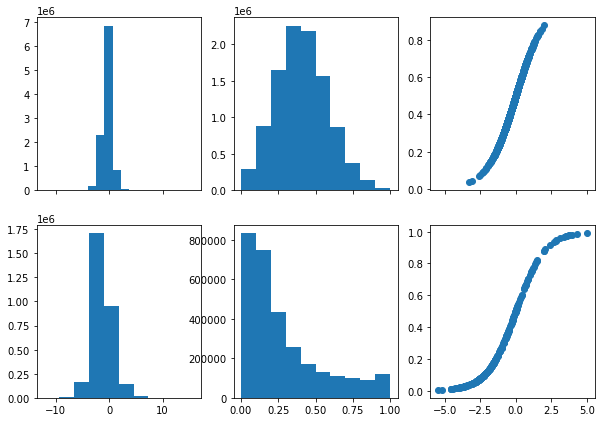

In [24]:
class MLPSigmoid(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLPSigmoid, self).__init__()
        
        self.hidden_layer1 = 1024
        self.hidden_layer2 = 300
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer1)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.act2 = nn.Sigmoid()
        self.fc3 = nn.Linear(self.hidden_layer2, out_features)
        
        
    def forward(self, x):
        output1 = self.fc1(x)
        hidden1 = self.act1(output1)
        
        output2 = self.fc2(hidden1)
        hidden2 = self.act2(output2)
        
        onehot_out = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, onehot_out
    

init_model(MLPSigmoid(len(train_0_x.view([-1])), 10).to(device))
plot_inner_dist()


### Epoch: 10  /  Accuracy: 0.9754999876022339 ###


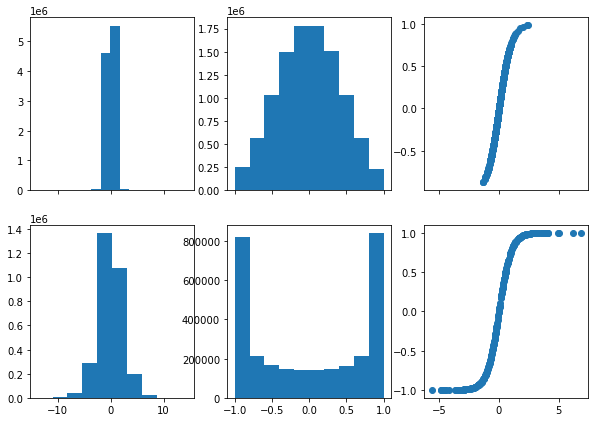

In [25]:
class MLPTanh(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLPTanh, self).__init__()
        
        self.hidden_layer1 = 1024
        self.hidden_layer2 = 300
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(self.hidden_layer2, out_features)
        
    def forward(self, x):
        output1 = self.fc1(x)
        hidden1 = self.act1(output1)
        
        output2 = self.fc2(hidden1)
        hidden2 = self.act2(output2)
        
        onehot_out = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, onehot_out

init_model(MLPTanh(len(train_0_x.view([-1])), 10).to(device))
plot_inner_dist()

![vanishing gradient](https://blog.kakaocdn.net/dn/C9g9a/btqBRviYlfG/ddLAyfZ0wY6biGjoEUDqtk/img.png)

### Plot inner distribution(MLP, ReLU)


### Epoch: 10  /  Accuracy: 0.9822999835014343 ###


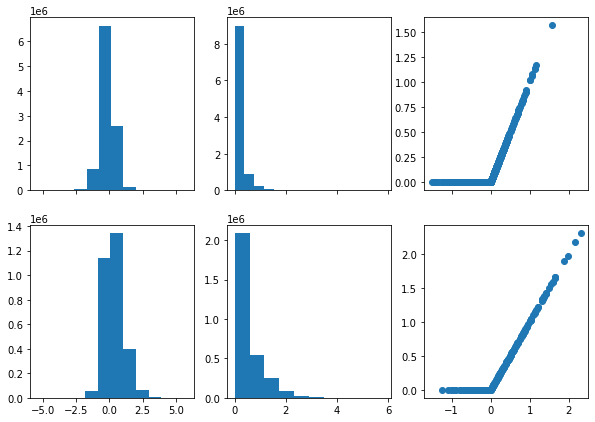

In [71]:
class MLPReLU(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLPReLU, self).__init__()
        
        self.hidden_layer1 = 1024
        self.hidden_layer2 = 300
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(self.hidden_layer2, out_features)
        
    def forward(self, x):
        output1 = self.fc1(x)
        hidden1 = self.act1(output1)
        
        output2 = self.fc2(hidden1)
        hidden2 = self.act2(output2)
        
        onehot_out = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, onehot_out
    
init_model(MLPReLU(len(train_0_x.view([-1])), 10).to(device))
plot_inner_dist()

### Batch Normalization Code(Sigmoid)


### Epoch: 10  /  Accuracy: 0.9680999517440796 ###


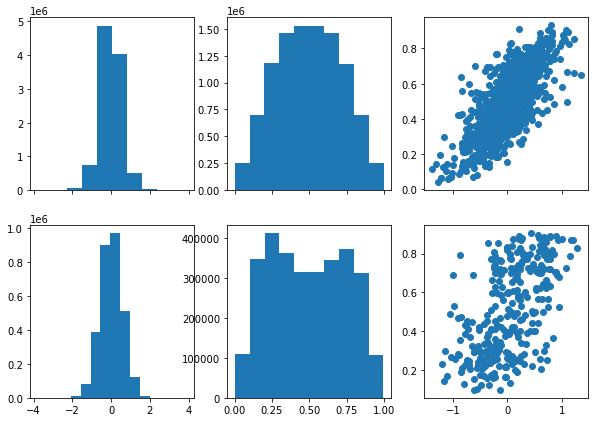

In [72]:
class MLPSigmoidBatchNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLPSigmoidBatchNorm, self).__init__()
        
        self.hidden_layer1 = 1024
        self.hidden_layer2 = 300
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer1)
        self.bn1 = nn.BatchNorm1d(self.hidden_layer1)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.bn2 = nn.BatchNorm1d(self.hidden_layer2)
        self.act2 = nn.Sigmoid()
        self.fc3 = nn.Linear(self.hidden_layer2, out_features)
        
        
    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)
        
        output2 = self.fc2(hidden1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        
        onehot_out = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, onehot_out
    
init_model(MLPSigmoidBatchNorm(len(train_0_x.view([-1])), 10).to(device))
plot_inner_dist()


### Epoch: 10  /  Accuracy: 0.9833999872207642 ###


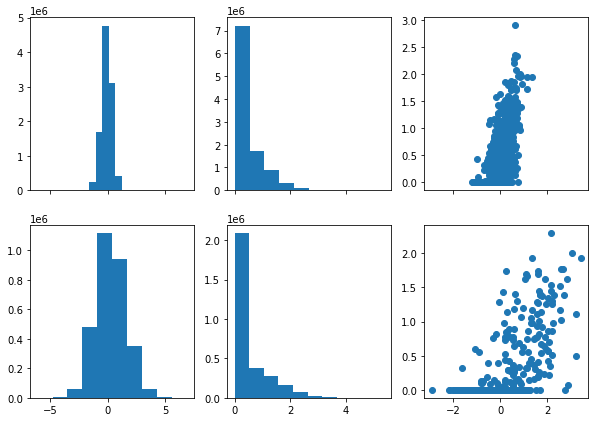

In [79]:
class MLPReLUBatchNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLPReLUBatchNorm, self).__init__()
        
        self.hidden_layer1 = 1024
        self.hidden_layer2 = 300
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer1)
        self.bn1 = nn.BatchNorm1d(self.hidden_layer1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.bn2 = nn.BatchNorm1d(self.hidden_layer2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(self.hidden_layer2, out_features)
        
    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)
        
        output2 = self.fc2(hidden1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        
        onehot_out = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, onehot_out
    
init_model(MLPReLUBatchNorm(len(train_0_x.view([-1])), 10).to(device))
plot_inner_dist()

## 8. Dropout

![dropout](http://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif)

In [28]:
class Dropout(nn.Module):
    def __init__(self, in_features, out_features):
        super(Dropout, self).__init__()
        
        self.hidden_layer = 32
        self.dropout_rate = .2  # probability
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(self.hidden_layer, out_features)
        
    def forward(self, x):
        hidden1 = self.act1(self.fc1(x))
        drop1 = self.drop1(hidden1)
        
        onehot_out = self.fc2(drop1)
        
        return onehot_out

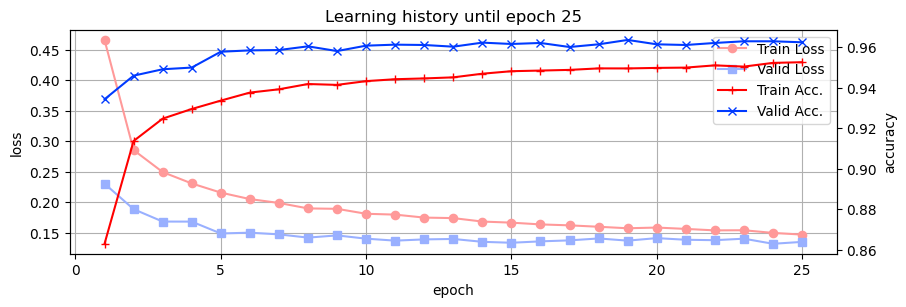

Iter:   25 >> T_loss 0.14718    T_acc 0.95265   V_loss 0.13519    V_acc 0.96250   🕒 5.805s
Iter:   24 >> T_loss 0.14993    T_acc 0.95232   V_loss 0.13210    V_acc 0.96300   🕒 5.880s
Iter:   23 >> T_loss 0.15429    T_acc 0.95049   V_loss 0.14046    V_acc 0.96300   🕒 5.891s
Iter:   22 >> T_loss 0.15406    T_acc 0.95110   V_loss 0.13799    V_acc 0.96217   🕒 5.912s
Iter:   21 >> T_loss 0.15648    T_acc 0.94999   V_loss 0.13871    V_acc 0.96117   🕒 5.900s
Iter:   20 >> T_loss 0.15870    T_acc 0.94984   V_loss 0.14138    V_acc 0.96150   🕒 5.852s
Iter:   19 >> T_loss 0.15754    T_acc 0.94958   V_loss 0.13726    V_acc 0.96367   🕒 5.866s
Iter:   18 >> T_loss 0.16001    T_acc 0.94960   V_loss 0.14084    V_acc 0.96150   🕒 5.827s
Iter:   17 >> T_loss 0.16232    T_acc 0.94886   V_loss 0.13769    V_acc 0.96017   🕒 5.879s
Iter:   16 >> T_loss 0.16386    T_acc 0.94852   V_loss 0.13607    V_acc 0.96217   🕒 5.845s
Iter:   15 >> T_loss 0.16675    T_acc 0.94821   V_loss 0.13378    V_acc 0.96167   🕒 5.852s

NameError: name 'test_laoader' is not defined

In [30]:
# Training Initialization
init_model(Dropout(len(train_0_x.view([-1])), 10))
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    net.train()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        net.eval()
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

# Accuracy for test dataset
with torch.no_grad():
    net.eval()
    test_loss, test_acc, test_out, test_label = epoch(test_loader)
    print('\n====================== Test Result ======================\n')
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')

## 9 Training Iteration & Test Result (Batch Norm & Dropout)

In [ ]:
    self.hidden_layer1 = 1024
        self.hidden_layer2 = 300
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer1)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.act2 = nn.Sigmoid()
        self.fc3 = nn.Linear(self.hidden_layer2, out_features)
        
        
        self.hidden_layer1 = 165
        self.hidden_layer2 = 165
        
        self.fc1 = nn.Linear(in_features, self.hidden_layer1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_layer1, self.hidden_layer2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(self.hidden_layer2, out_features)
        

### Dropout의 효과
- DropOut을 하면 Ensemble한 효과도 있다.

In [39]:
class MLPDropout(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLPDropout, self).__init__()
        
        self.hidden_layer1 = 165
        self.hidden_layer2 = 165
        self.dropout_rate = 0.2  # probability
        
        self.layer1 = nn.Sequential(
            nn.Linear(in_features, self.hidden_layer1),
            nn.BatchNorm1d(self.hidden_layer1),
            nn.ReLU(), 
            nn.Dropout(self.dropout_rate)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(self.hidden_layer1, self.hidden_layer2),
            nn.BatchNorm1d(self.hidden_layer2),
            nn.ReLU(), 
            nn.Dropout(self.dropout_rate)
        )
        self.out_layer = nn.Linear(self.hidden_layer2, out_features)
        
    def forward(self, x):
        hidden1 = self.layer1(x)
        hidden2 = self.layer2(hidden1)
        
        onehot_out = self.out_layer(hidden2)
        return onehot_out

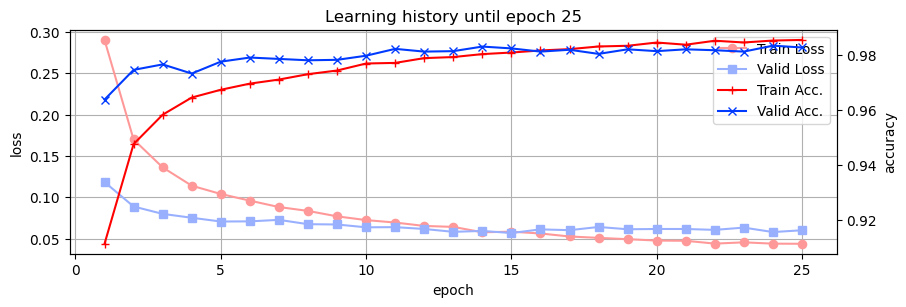

Iter:   25 >> T_loss 0.04392    T_acc 0.98559   V_loss 0.06027    V_acc 0.98283   🕒 6.553s
Iter:   24 >> T_loss 0.04407    T_acc 0.98537   V_loss 0.05807    V_acc 0.98350   🕒 7.758s
Iter:   23 >> T_loss 0.04566    T_acc 0.98466   V_loss 0.06348    V_acc 0.98133   🕒 6.555s
Iter:   22 >> T_loss 0.04413    T_acc 0.98529   V_loss 0.06073    V_acc 0.98183   🕒 5.748s
Iter:   21 >> T_loss 0.04752    T_acc 0.98385   V_loss 0.06179    V_acc 0.98217   🕒 5.734s
Iter:   20 >> T_loss 0.04779    T_acc 0.98464   V_loss 0.06180    V_acc 0.98150   🕒 5.745s
Iter:   19 >> T_loss 0.04948    T_acc 0.98346   V_loss 0.06147    V_acc 0.98217   🕒 5.751s
Iter:   18 >> T_loss 0.05106    T_acc 0.98320   V_loss 0.06423    V_acc 0.98050   🕒 5.788s
Iter:   17 >> T_loss 0.05275    T_acc 0.98224   V_loss 0.06038    V_acc 0.98200   🕒 7.735s
Iter:   16 >> T_loss 0.05636    T_acc 0.98175   V_loss 0.06134    V_acc 0.98133   🕒 7.731s
Iter:   15 >> T_loss 0.05853    T_acc 0.98099   V_loss 0.05691    V_acc 0.98250   🕒 6.688s

In [40]:
# Training Initialization
init_model(MLPDropout(len(train_0_x.view([-1])), 10))
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    net.train()
    tloss, tacc, _, _ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        net.eval()
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

# Accuracy for test dataset
with torch.no_grad():
    net.eval()
    test_loss, test_acc, test_out, test_label = epoch(test_loader)
    print('\n====================== Test Result ======================\n')
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')